In [6]:
import os
import pickle
import json

import librosa
import math

import hmmlearn.hmm as hmm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from preprocessing import get_mfcc

from utils import  get_all_words

import seaborn as sns
import matplotlib.pyplot as plt

# 1.Params

In [7]:
class_names = get_all_words()
states = np.ones(len(class_names), dtype=int) * 3
n_mix = 2

In [8]:
dataset_path = '../datasets/split'

model_path = '../models'

In [9]:
def load_data(dataset_path: str, class_names: str):
    length = 0
    for cn in class_names:
        length += len(os.listdir(f"{dataset_path}/{cn}"))
    print('Total samples:', length)

    X = {'train': {}, 'test': {}}
    y = {'train': {}, 'test': {}}

    all_data = {}
    all_labels = {}
    for cname in class_names:
        file_paths = [os.path.join(dataset_path, cname, i) for i in os.listdir(
            os.path.join(dataset_path, cname)) if i.endswith('.wav')]
        data = [get_mfcc(file_path) for file_path in file_paths]
        all_data[cname] = data
        all_labels[cname] = [class_names.index(cname) for _ in range(len(file_paths))]

    for cname in class_names:
        x_train, x_test, y_train, y_test = train_test_split(
            all_data[cname], all_labels[cname],
            test_size=0.33,
            random_state=42
        )

        X['train'][cname] = x_train
        X['test'][cname] = x_test
        y['test'][cname] = y_test

    total_train = 0
    total_test = 0
    for cname in class_names:
        train_count = len(X['train'][cname])
        test_count = len(X['test'][cname])
        print(cname, 'train:', train_count, '| test:', test_count)
        total_train += train_count
        total_test += test_count
    print('train samples:', total_train)
    print('test samples', total_test)

    return X, y

In [10]:
X, y = load_data(dataset_path, class_names)

Total samples: 1040
chu train: 13 | test: 7
ve train: 13 | test: 7
vao train: 13 | test: 7
tai train: 13 | test: 7
dau train: 13 | test: 7
cuoi train: 13 | test: 7
ke train: 13 | test: 7
truoc train: 13 | test: 7
dung train: 13 | test: 7
ngung train: 13 | test: 7
doc train: 13 | test: 7
tiep train: 13 | test: 7
lui train: 13 | test: 7
toi train: 13 | test: 7
tang train: 13 | test: 7
to train: 13 | test: 7
giam train: 13 | test: 7
nho train: 13 | test: 7
lai train: 13 | test: 7
lap train: 13 | test: 7
nhanh train: 13 | test: 7
cham train: 13 | test: 7
luu train: 13 | test: 7
xoa train: 13 | test: 7
huy train: 13 | test: 7
chay train: 13 | test: 7
xong train: 13 | test: 7
ddung train: 13 | test: 7
sai train: 13 | test: 7
giup train: 13 | test: 7
gio train: 13 | test: 7
ngay train: 13 | test: 7
tuoi train: 13 | test: 7
co train: 13 | test: 7
khong train: 13 | test: 7
muc train: 13 | test: 7
bai train: 13 | test: 7
mot train: 13 | test: 7
hai train: 13 | test: 7
ba train: 13 | test: 7
bon 

# 2. Training

In [11]:
def train(X: dict[str, dict], class_names: list[str], states: list[int], n_mix: int = 2):
    models = {}
    likelihoods = {}

    for idx, cname in enumerate(class_names):
        start_prob = np.full(states[idx], 0.0)
        start_prob[0] = 1.0
        trans_matrix = np.full((states[idx], states[idx]), 0.0)
        p = 0.5
        np.fill_diagonal(trans_matrix, p)
        np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
        trans_matrix[-1, -1] = 1.0
        trans_matrix = trans_matrix / (states[idx])

        # trans matrix
        print(cname)
        print(trans_matrix)
        
        models[cname] = hmm.GMMHMM(
            n_components=states[idx],
            n_mix=n_mix,
            verbose=False,
            n_iter=300,
            startprob_prior=start_prob,
            transmat_prior=trans_matrix,
            params='stmc',
            init_params='mc',
            random_state=42
        )

        models[cname].fit(X=np.vstack(X['train'][cname]),
                                lengths=[x.shape[0] for x in X['train'][cname]])

        likelihoods[cname] = models[cname].monitor_.history

    return models, likelihoods

In [12]:
models, likelihoods = train(X, class_names, states, n_mix)

chu
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
ve
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
vao
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
tai
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
dau
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
cuoi
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
ke
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
truoc
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
dung
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.   

Model is not converging.  Current: -186512.5687401852 is not greater than -186490.0886482126. Delta is -22.48009197259671


lap
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
nhanh
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
cham
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
luu
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
xoa
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
huy
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
chay
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
xong
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
ddung
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         

Model is not converging.  Current: -178099.4310726817 is not greater than -178098.1534879611. Delta is -1.2775847206066828


tuoi
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
co
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
khong
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
muc
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
bai
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
mot
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
hai
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
ba
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
bon
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.    

In [13]:
def show_prob(models: dict[str, hmm.GMMHMM], class_names: list[str]):
    for cname in class_names:
        print("\nMa trận chuyển tiếp trạng thái ẩn của \"" + cname +"\":")
        print(models[cname].transmat_)

show_prob(models, class_names)


Ma trận chuyển tiếp trạng thái ẩn của "chu":
[[0.94999429 0.01044201 0.0395637 ]
 [0.06141295 0.93027758 0.00830947]
 [0.         0.00842536 0.99157464]]

Ma trận chuyển tiếp trạng thái ẩn của "ve":
[[0.99157339 0.         0.00842661]
 [0.         0.9514081  0.0485919 ]
 [0.04166713 0.03923035 0.91910252]]

Ma trận chuyển tiếp trạng thái ẩn của "vao":
[[0.99184176 0.         0.00815824]
 [0.         0.96422115 0.03577885]
 [0.03654242 0.03625329 0.92720429]]

Ma trận chuyển tiếp trạng thái ẩn của "tai":
[[0.94878422 0.         0.05121578]
 [0.00858194 0.99141806 0.        ]
 [0.002745   0.03287749 0.96437751]]

Ma trận chuyển tiếp trạng thái ẩn của "dau":
[[0.99153157 0.00846843 0.        ]
 [0.         0.95434247 0.04565753]
 [0.04142427 0.         0.95857573]]

Ma trận chuyển tiếp trạng thái ẩn của "cuoi":
[[0.99074305 0.00925695 0.        ]
 [0.04824062 0.90674956 0.04500983]
 [0.         0.04849016 0.95150984]]

Ma trận chuyển tiếp trạng thái ẩn của "ke":
[[0.9916742  0.0083258  0

# 3. Evaluation

In [14]:
def evaluation(model: dict, X: dict[str, dict], y: dict[str, dict], class_names: list[str]):
    import numpy as np
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    y_true = []
    y_pred = []
    
    # Duyệt qua từng lớp
    for cname in class_names:
        true_for_class = []
        pred_for_class = []
        
        # Duyệt qua từng mẫu của lớp
        for mfcc, target in zip(X['test'][cname], y['test'][cname]):
            try:
                # Tính điểm số
                scores = [model[c].score(mfcc) for c in class_names]
                pred = np.argmax(scores)
                
                # Lưu kết quả
                true_for_class.append(target)
                pred_for_class.append(pred)
            except Exception as e:
                print(f"Error processing sample for class {cname}: {e}")

        # Cập nhật danh sách chung
        y_true.extend(true_for_class)
        y_pred.extend(pred_for_class)
        
        # Accuracy cho từng lớp
        if len(true_for_class) > 0:
            acc = np.sum(np.array(true_for_class) == np.array(pred_for_class)) / len(true_for_class)
            print(f'{cname}: {acc:.2f}')
        else:
            print(f'{cname}: No data to evaluate.')

    # Ma trận nhầm lẫn
    print('======')
    print('Confusion matrix:')
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    print(cm)

    # Accuracy tổng thể
    overall_acc = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true) if len(y_true) > 0 else 0
    print('Accuracy:', overall_acc)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap="Blues")
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

chu: 0.71
ve: 0.71
vao: 0.71
tai: 0.57
dau: 0.43
cuoi: 0.86
ke: 0.86
truoc: 0.86
dung: 0.86
ngung: 0.57
doc: 0.71
tiep: 0.71
lui: 0.57
toi: 0.71
tang: 0.43
to: 0.71
giam: 0.71
nho: 0.71
lai: 0.71
lap: 0.86
nhanh: 0.71
cham: 0.71
luu: 0.71
xoa: 0.14
huy: 0.71
chay: 0.71
xong: 0.14
ddung: 0.71
sai: 0.43
giup: 0.71
gio: 0.86
ngay: 0.57
tuoi: 0.57
co: 0.71
khong: 0.71
muc: 0.57
bai: 0.71
mot: 0.57
hai: 0.71
ba: 0.57
bon: 0.71
nam: 0.71
sau: 0.86
bay: 0.71
tam: 0.57
chin: 0.71
a: 0.71
e: 0.71
i: 0.71
o: 0.43
u: 0.86
thodia: 0.86
Confusion matrix:
[[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 6]]
Accuracy: 0.6703296703296703


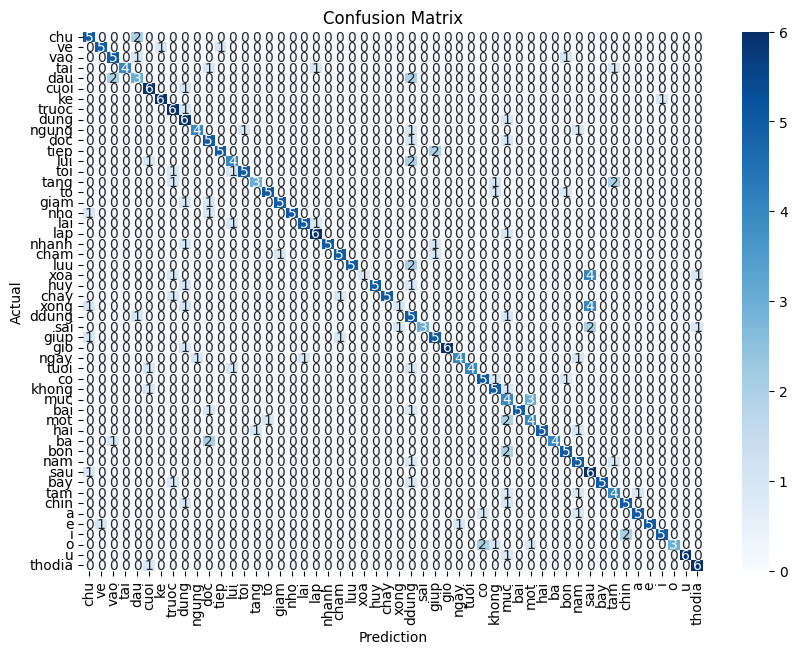

In [15]:
evaluation(models, X, y, class_names)

# 4. Save model

In [16]:
def save_model(models: dict, class_names, model_path: str, model_key: str):
    print(f'Saving models to {model_path}/{model_key}')
    if not os.path.exists(f'{model_path}/{model_key}'):
            os.makedirs(f'{model_path}/{model_key}')
    for cname in class_names:
        name = f'{model_path}/{model_key}/model_{cname}.pkl'
        
        with open(name, 'wb') as file:
            pickle.dump(models[cname], file)
    print('Save params to json')
    with open(f'{model_path}/{model_key}/params.json', 'w') as file:
        file.write(json.dumps({
            'n_states': [int(i) for i in states],
            'n_mix': n_mix,
        }))

In [17]:
save_model(models, class_names, model_path, f"demo")

Saving models to ../models/demo
Save params to json
